In [1941]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE
import matplotlib.pyplot as plt

### Read in Data

In [1942]:
%store -r correlative_factors
correlative_factors.pop('saleprice', None)

# training data
house_train = pd.read_csv('../datasets/house_train_improved.csv')
# testing data
house_test = pd.read_csv('../datasets/house_test_improved.csv')
# increase column width
pd.set_option('display.max_columns', 300)

In [1943]:
drop = ['updated', 'heating_qc', 'fireplaces', 'total_porch_sf', 'garage_area', 'garage_age', 'lot_area']
correlative_factors = {k:v for k,v in correlative_factors.items() if v not in drop}

### Log and Sqrt Transformations of Skewed Features

In [1944]:
### Feature Transformation

sqrt_vars = ['gr_liv_area', 'total_bsmt_sf', 'house_age']
for col in sqrt_vars:
    house_train[col] = np.sqrt(house_train[col])
    house_test[col] = np.sqrt(house_test[col])
log_vars = ['lot_area', 'lot_frontage', 'land_house_ratio']
for col in log_vars:
    house_train[col] = np.log(house_train[col])
    house_test[col] = np.log(house_test[col])
    

### Log Sale Price

In [1945]:
house_train.saleprice = np.log(house_train.saleprice)

### Cross Validation

In [1946]:
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# FEATURES  = ['totrms_abvgrd', 'garage_cars', '1st_flr_sf', 'gr_liv_area', 
    #   'garage_area', 'overall_qual', 'exter_qual', 'bsmt_qual', 'kitchen_qual']

FEATURES = correlative_factors.keys()


X = house_train[FEATURES]
y = house_train.saleprice
X_test = house_test[FEATURES]

X_train, X_val, y_train, y_val = train_test_split(X, y)


ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())


mlr = LassoCV(alphas = np.arange(0.001, 10, 1))
# mlr = Ridge()
# mlr = Lasso()
# mlr = LinearRegression()
# train it

scores_1 = (cross_val_score(mlr, Xs_train, y_train, cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=42)))
# cross val score
scores_1.mean()

0.8917869614575465

Fit Model

In [1947]:
#calculate residuals by creating predictions
mlr.fit(Xs_train,y_train)
preds = mlr.predict(Xs_train)
resid = y_train - preds

Scores 

In [1948]:
mlr.score(Xs_val, y_val)

0.8597557709536254

In [1949]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.exp(preds), np.exp(y_train), squared = False)

27030.454016394433

Variance Inflation Factor

In [1950]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns;

vif.head(50)

,VIF Factor,features
0,31.667412,bedroom_abvgr
1,87.894145,kitchen_abvgr
2,84.067186,totrms_abvgrd
3,12.033835,fireplaces
4,41.653350,garage_cars
5,447.747205,lot_frontage
6,2538.850180,lot_area
7,2.048081,mas_vnr_area
8,60.959860,total_bsmt_sf
9,502.989659,gr_liv_area


Columns Lasso is Minimizing

In [1951]:

squashed_columns = []
for idx, item in enumerate(mlr.coef_):
    if item == 0:
        squashed_columns.append(idx)
    
squashed_columns
Xs_train.iloc[:,squashed_columns].columns

Index(['bedroom_abvgr', 'totrms_abvgrd', 'alley', 'CBlock', 'PConc', 'Duplex',
       'Twnhs', 'CemntBd', 'MeadowV', 'NAmes', 'NoRidge', 'Somerst', 'Timber',
       'land_house_ratio', 'has_pool'],
      dtype='object')

### Fit Plot

Text(0.5, 1.0, 'Predicted vs. Actual')

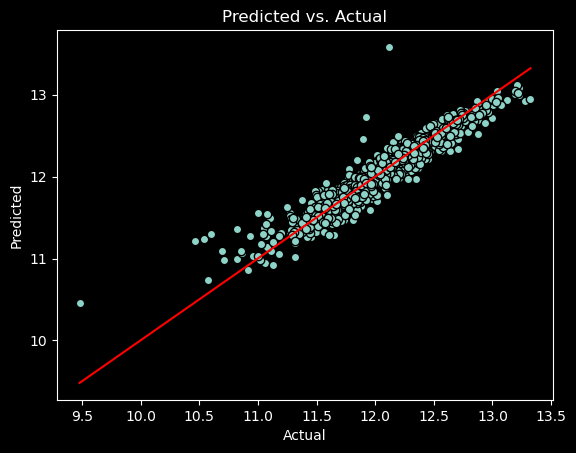

In [1952]:
fig, ax = plt.subplots()
ax.scatter(y_train, preds, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],'r')

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Predicted vs. Actual')

### Residuals vs. Fits

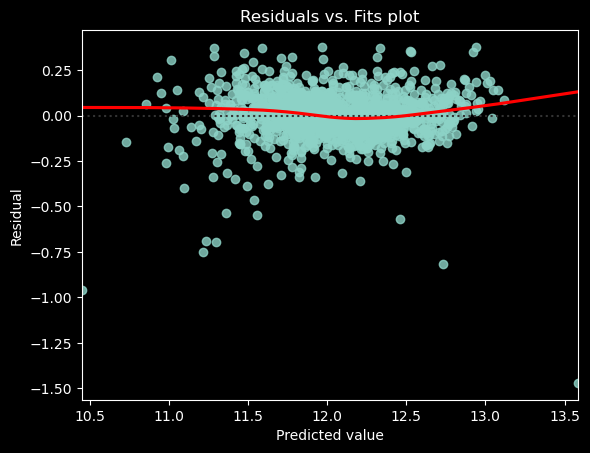

In [1953]:
sns.residplot(x = preds,
              y = resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

### QQ Plot

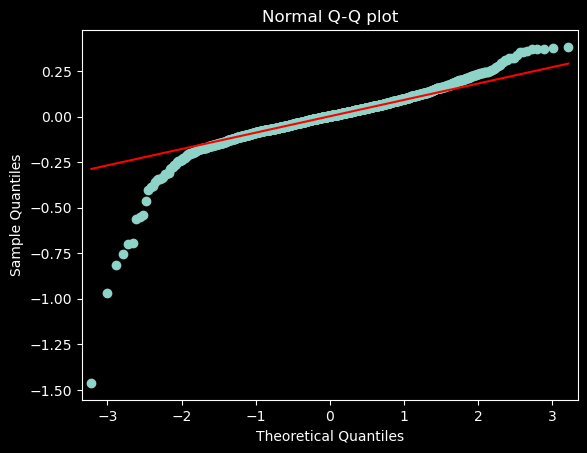

In [1954]:

sm.qqplot(resid,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot');

Statsmodels

In [1955]:
X_sm = sm.add_constant(X_train)

res = sm.OLS(y_train, X_sm).fit()
preds = res.predict(sm.add_constant(X_test))
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     236.5
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:37:14   Log-Likelihood:                 1065.4
No. Observations:                1538   AIC:                            -2003.
Df Residuals:                    1474   BIC:                            -1661.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       6.6346      0.522     12.719      0.000       5.611       7.658
bedroom_abvgr               0.0020      0.006      0.323      0.747      -0.010       0.014
kitchen_abvgr              -0.0582      0.026     -2.203      0.028      -0.110      -0.006
totrms_abvgrd              -0.0026      0.004     -0.583      0.560      -0.011       0.006
fireplaces                  0.0424      0.013      3.355      0.001       0.018       0.067
garage_cars                 0.0179      0.010      1.709      0.088      -0.003       0.038
lot_frontage                0.0058      0.016      0.364      0.716      -0.025       0.037
lot_area                    0.5853      0.096      6.070      0.000       0.396       0.775
mas_vnr_area             -1.38e-05   2.29e-05     -0.603      0.547   -5.87e-05    3.11e-05
total_bsmt_sf               0.0029      0.001      3.923      0.000       0.001       0.004
gr_liv_area                -0.0049      0.005     -0.967      0.334      -0.015       0.005
garage_area              5.305e-05   3.65e-05      1.453      0.146   -1.86e-05       0.000
wood_deck_sf             9.366e-05   2.77e-05      3.375      0.001    3.92e-05       0.000
heating_qc                  0.0194      0.005      4.289      0.000       0.011       0.028
kitchen_qual                0.0252      0.008      3.192      0.001       0.010       0.041
functional                  0.0529      0.005     11.063      0.000       0.044       0.062
paved_drive                 0.0631      0.014      4.433      0.000       0.035       0.091
fence                      -0.0050      0.009     -0.568      0.570      -0.022       0.012
alley                      -0.0030      0.016     -0.191      0.848      -0.034       0.028
central_air                 0.0675      0.016      4.221      0.000       0.036       0.099
has_fireplace              -0.0036      0.016     -0.228      0.820      -0.035       0.028
Artery                     -0.0344      0.027     -1.280      0.201      -0.087       0.018
Feedr                      -0.0024      0.023     -0.107      0.915      -0.047       0.042
Norm                        0.0483      0.018      2.656      0.008       0.013       0.084
PosN                        0.0628      0.033      1.917      0.055      -0.001       0.127
BrkTil                     -0.0114      0.014     -0.803      0.422      -0.039       0.016
CBlock                     -0.0507      0.093     -0.546      0.585      -0.233       0.131
PConc                      -0.0029      0.012     -0.249      0.803      -0.025       0.020
Slab                       -0.0143      0.035     -0.409      0.683      -0.083       0.054
1Fam                        0.0405      0.018      2.262      0.024       0.005       0.076
2fmCon                      0.0446      0.031  

# Submission

In [1956]:
#E instantiate lasso with best alpha 

# mlr.fit(X_train, y_train)

ss = StandardScaler()
Xs_test = ss.fit_transform(X_test)
Xs_test = pd.DataFrame(Xs_test, columns = ss.get_feature_names_out())

price_preds = mlr.predict(Xs_test)
house_test['SalePrice'] = np.exp(price_preds)

house_test
house_test[['id', 'SalePrice']].to_csv('../datasets/submission.csv', index = False)

In [1957]:
house_test[['id', 'SalePrice']]

house_test

c:\Users\alexs\anaconda3\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_cond,foundation,bsmt_exposure,total_bsmt_sf,heating,heating_qc,central_air,electrical,gr_liv_area,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,garage_type,garage_finish,garage_cars,garage_area,paved_drive,wood_deck_sf,pool_area,fence,misc_val,mo_sold,sale_type,has_fireplace,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,Greens,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1Fam,2fmCon,Duplex,Twnhs,TwnhsE,AsbShng,AsphShn,BrkComm,BrkFace,CemntBd,HdBoard,MetalSd,Plywood,Stucco,VinylSd,Wd Sdng,WdShing,BrkTil,CBlock,PConc,Slab,Stone,Wood,CompShg,Tar&Grv,WdShake,WdShngl,AllPub,NoSewr,Artery.1,Feedr.1,Norm.1,PosA.1,PosN.1,RRAe.1,RRAn.1,RRNe.1,RRNn.1,overall_qual_cond,basement_cond,2nd_story,total_bath,total_porch_sf,neighborhood_price_rank,updated,garage_age,garage_qual_cond,house_age,land_house_ratio,has_pool,meltdown,SalePrice
0,2658,902301120,190,RM,4.234107,9.120634,Pave,1,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,8,Gable,CompShg,AsbShng,AsbShng,None,0.0,1,Stone,NaN,31.937439,GasA,3,0,FuseP,43.908997,4,2,1,9,3,0,Detchd,Unf,1,440,1,0,0,0,0,4,WD,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,4.0,1.333333,1,2.0,172,24,40,96.0,0.0,9.797959,1.556396,0,0,114297.721600
1,2718,905108090,90,RL,4.241988,9.175956,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,Gable,CompShg,Plywood,Plywood,None,0.0,2,CBlock,NaN,44.350874,GasA,2,1,SBrkr,44.350874,6,2,2,10,3,0,Attchd,Fin,2,580,1,170,0,0,0,8,WD,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,3.5,1.333333,0,2.0,0,19,0,29.0,2.0,5.385165,1.591691,0,0,167198.573810
2,2414,528218130,60,RL,4.060443,9.747068,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,PConc,NaN,25.573424,GasA,4,1,SBrkr,38.678159,3,1,3,7,3,1,Attchd,RFn,2,426,1,100,0,0,0,9,New,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,5.0,3.333333,1,3.5,24,12,0,0.0,2.0,0.000000,2.436517,0,1,235551.083446
3,1989,902207150,30,RM,4.094345,9.050172,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,2,CBlock,NaN,31.112698,GasA,2,1,SBrkr,31.112698,2,1,2,5,3,0,Detchd,Unf,2,480,0,0,0,0,0,7,WD,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,4.0,1.333333,0,1.0,184,24,83,72.0,1.5,9.165151,2.174940,0,0,114936.208602
4,625,535105100,20,RL,4.241988,9.159047,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,2,CBlock,NaN,37.336309,GasA,3,1,SBrkr,37.336309,3,1,2,6,3,2,Attchd,RFn,2,514,1,0,0,0,0,7,WD,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,4.0,2.333333,0,2.5,261,16,0,46.0,2.0,6.782330,1.919114,0,0,178361.985566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,